In [1]:
from typing import Callable
from dataclasses import dataclass
from evaluation.eval_analysis import (
    find_shared_proofs,
    filter_all_successful,
    filter_all_failure,
    filter_all_no_error,
    EvalDict,
    PlotInfo,
    time_key,
    expanded_key,
    num_proofs,
    get_combined_num_proofs_by_metric,
    SuccessMetric,
    LengthRange,
    SuccessResult,
)
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/coq-modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-02-18 23:48:31,943] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
EVAL_DIRS = [
    #("Full dataset", "/home/ubuntu/coq-modeling/evals/codellama-7b-basic-rnd-split"),
    #("15% dataset", "/home/ubuntu/coq-modeling/evals/codellama-7b-basic-rnd-split-rnd-samp-15-pct"),
    ("8% dataset", "/home/ubuntu/coq-modeling/evals/codellama-7b-basic-rnd-split-rnd-samp-8-pct"),
    ("8% dataset prf selection", "/home/ubuntu/coq-modeling/evals/codellama-7b-proof-ret-rnd-split-rnd-samp-8-pct"),
    #("8% dataset w/ tpe (n tactics)", "/home/ubuntu/coq-modeling/evals/codellama-7b-tpe-1k-rnd-split-rnd-samp-8-pct"),
    #("8% dataset w/ tpe (n tactics) & fallback", "/home/ubuntu/coq-modeling/evals/codellama-7b-tpe-1k-fallback-rnd-split-rnd-samp-8-pct"),
    #("8% dataset w/ tpe (n tactics) & fallback 2", "/home/ubuntu/coq-modeling/evals/codellama-7b-tpe-1k-fallback-2-rnd-split-rnd-samp-8-pct"),
    #("8% dataset w/ optimal prf retrieval", "/home/ubuntu/coq-modeling/evals/codellama-7b-prf-oracle-rnd-split-rnd-samp-8-pct"),
    ("8% dataset w/ premise selection", "/home/ubuntu/coq-modeling/evals/codellama-7b-premise-rnd-split-rnd-samp-8-pct"),
    #("8% dataset w/ premise selection no coq", "/home/ubuntu/coq-modeling/evals/codellama-7b-premise-no-coq-rnd-split-rnd-samp-8-pct"),

]

In [3]:
eval_dirs = [b for _, b in EVAL_DIRS]
shared_proof_names = find_shared_proofs(eval_dirs)

In [4]:
eval_dicts = [EvalDict.from_shared_proofs(e, p, shared_proof_names) for e, p in EVAL_DIRS]

In [5]:

def get_matching_x_axes(
    eval_dicts: list[EvalDict], metric: SuccessMetric
) -> tuple[list[PlotInfo], PlotInfo]:
    plot_infos = [ed.get_num_proofs_by_metric(metric) for ed in eval_dicts]
    max_metric = max([p.xs[-1] for p in plot_infos])

    for plot_info in plot_infos:
        if plot_info.xs[-1] != max_metric:
            plot_info.xs.append(max_metric)
            plot_info.ys.append(plot_info.ys[-1])
    
    combined_plot_info = get_combined_num_proofs_by_metric(eval_dicts, metric)
    if combined_plot_info.xs[-1] != max_metric:
        combined_plot_info.xs.append(max_metric)
        combined_plot_info.ys.append(combined_plot_info.ys[-1])

    return plot_infos, combined_plot_info 


  

# Errors Included in Eval

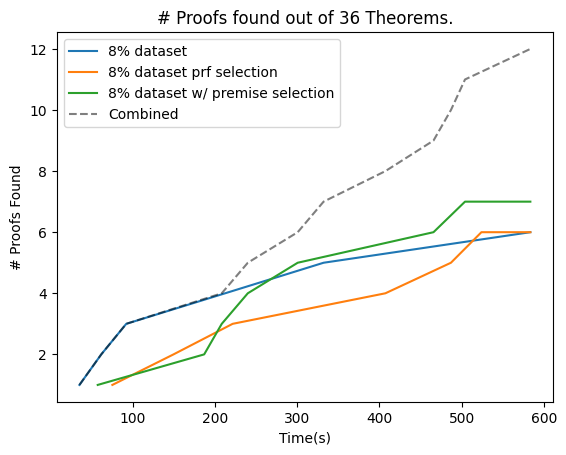

In [6]:
def plot_by_time(shared_proofs: set[str], eval_dicts: list[EvalDict]) -> None:
    fig, ax = plt.subplots()
    assert type(ax) == plt.Axes

    plot_infos, combined_plot_info = get_matching_x_axes(eval_dicts, time_key)

    for plot_info in plot_infos: 
        ax.plot(plot_info.xs, plot_info.ys, label=plot_info.name)

    ax.plot(combined_plot_info.xs, combined_plot_info.ys, "--", label=combined_plot_info.name, color="black", alpha=0.5,)

    ax.legend()
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("# Proofs Found")
    ax.set_title(f"# Proofs found out of {len(shared_proofs)} Theorems.")

plot_by_time(shared_proof_names, eval_dicts)


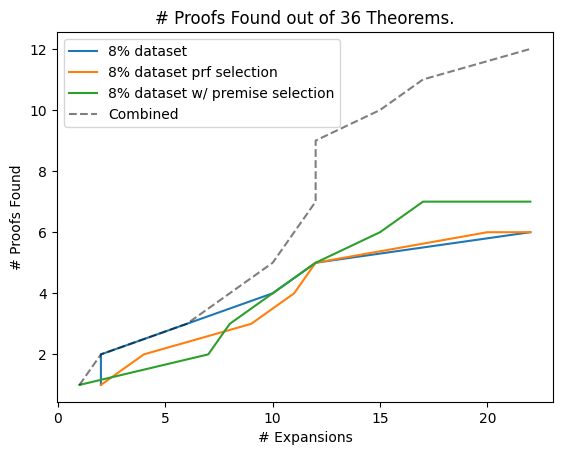

In [7]:
def plot_by_expansions(shared_proofs: set[str], eval_dicts: list[EvalDict]) -> None:
    fig, ax = plt.subplots()
    assert type(ax) == plt.Axes

    plot_infos, combined_plot_info = get_matching_x_axes(eval_dicts, expanded_key)

    for plot_info in plot_infos: 
        ax.plot(plot_info.xs, plot_info.ys, label=plot_info.name)

    ax.plot(combined_plot_info.xs, combined_plot_info.ys, "--", label=combined_plot_info.name, color="black", alpha=0.5,)


    ax.legend()
    ax.set_xlabel("# Expansions")
    ax.set_ylabel("# Proofs Found")
    ax.set_title(f"# Proofs Found out of {len(shared_proofs)} Theorems.")

plot_by_expansions(shared_proof_names, eval_dicts)

In [8]:
ranges = [
    LengthRange(0, 5),
    LengthRange(6, 10),
    LengthRange(11, 2000),
]

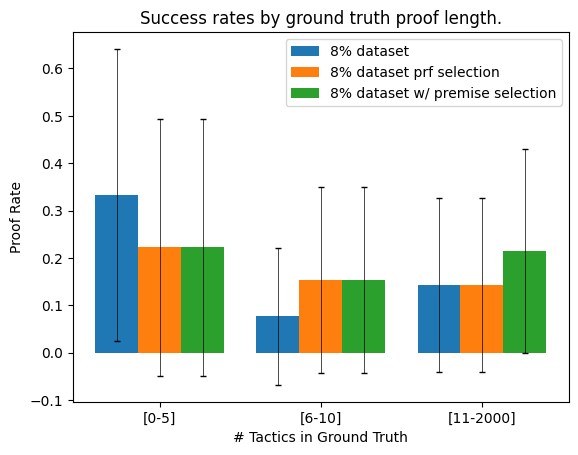

In [9]:
def plot_by_ground_truth(shared_proofs: set[str], eval_dicts: list[EvalDict]) -> None:
    rates_by_eval = [e.get_proof_rate_by_length(ranges) for e in eval_dicts] 
    fig, ax = plt.subplots()

    bar_width = 0.8 / len(rates_by_eval)
    xs = np.arange(len(ranges))
    for i, (eval_dict, rates) in enumerate(zip(eval_dicts, rates_by_eval)):
        shift_factor = bar_width * (i - (len(rates_by_eval) // 2))
        if len(rates_by_eval) % 2 == 0:
            shift_factor += bar_width / 2
        
        plot_xs = xs + shift_factor
        plot_ys = [r.rate() for r in rates]
        plot_errs = [r.margin() for r in rates]

        ax.errorbar(plot_xs, plot_ys, yerr=plot_errs, fmt="none", ecolor="black", capsize=2, elinewidth=0.5)
        ax.bar(plot_xs, plot_ys, bar_width, label=eval_dict.eval_name)

    ax.set_title("Success rates by ground truth proof length.")
    ax.set_xticks(xs)
    ax.set_xticklabels([r.label() for r in ranges])
    ax.set_xlabel("# Tactics in Ground Truth")
    ax.set_ylabel("Proof Rate")
    ax.legend()

plot_by_ground_truth(shared_proof_names, eval_dicts)


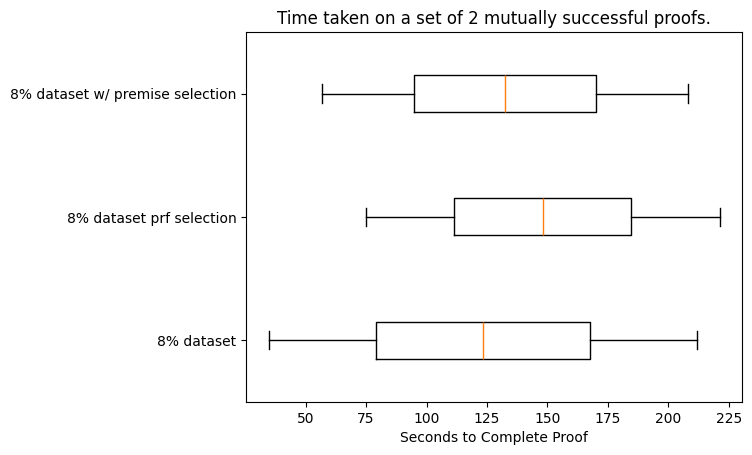

In [10]:
def successful_time_boxplot(shared_proofs: set[str], eval_dicts: list[EvalDict]) -> None:
    all_successful_proofs = filter_all_successful(shared_proofs, eval_dicts)
    filtered_dicts = [e.filter(all_successful_proofs) for e in eval_dicts]
    times = [e.get_successful_times() for e in filtered_dicts]
    labels = [e.eval_name for e in filtered_dicts]

    fig, ax = plt.subplots()
    ax.boxplot(times, vert=False, labels=labels)
    ax.set_xlabel("Seconds to Complete Proof")
    ax.set_title(f"Time taken on a set of {len(all_successful_proofs)} mutually successful proofs.")

successful_time_boxplot(shared_proof_names, eval_dicts)

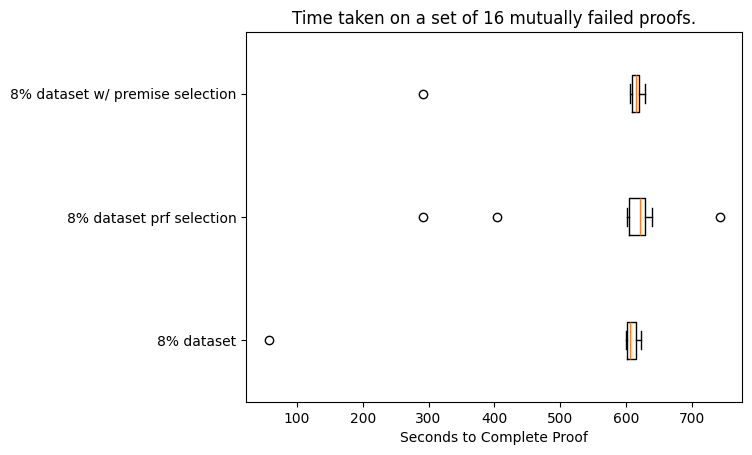

In [11]:
def failure_time_boxplot(shared_proofs: set[str], eval_dicts: list[EvalDict]) -> None:
    all_failed_proofs = filter_all_failure(shared_proofs, eval_dicts)
    filtered_dicts = [e.filter(all_failed_proofs) for e in eval_dicts]
    times = [e.get_failed_times() for e in filtered_dicts]
    labels = [e.eval_name for e in filtered_dicts]

    fig, ax = plt.subplots()
    ax.boxplot(times, vert=False, labels=labels)
    ax.set_xlabel("Seconds to Complete Proof")
    ax.set_title(f"Time taken on a set of {len(all_failed_proofs)} mutually failed proofs.")

failure_time_boxplot(shared_proof_names, eval_dicts)

# Errors Omitted in Eval

In [12]:
error_free_names = filter_all_no_error(shared_proof_names, eval_dicts)
error_free_eval = [e.filter(error_free_names) for e in eval_dicts]

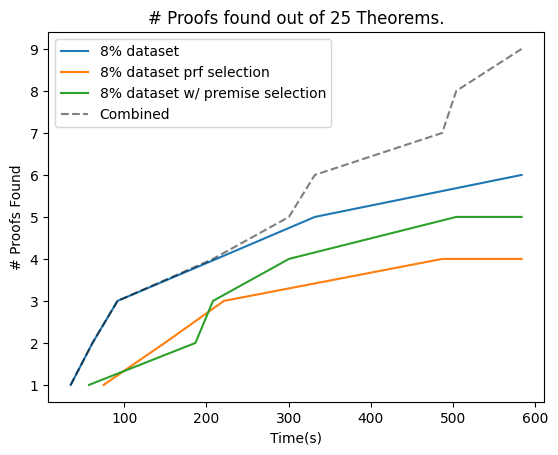

In [13]:
plot_by_time(error_free_names, error_free_eval)

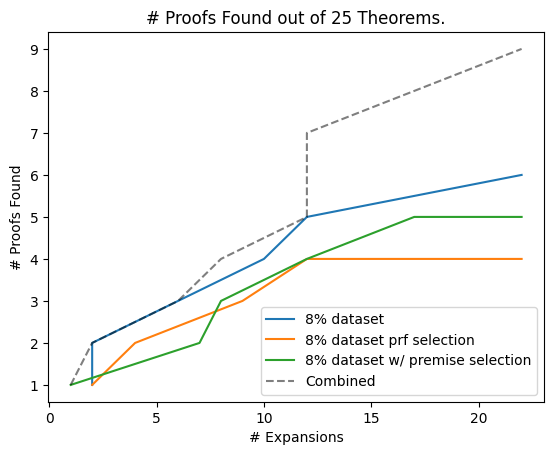

In [14]:
plot_by_expansions(error_free_names, error_free_eval)

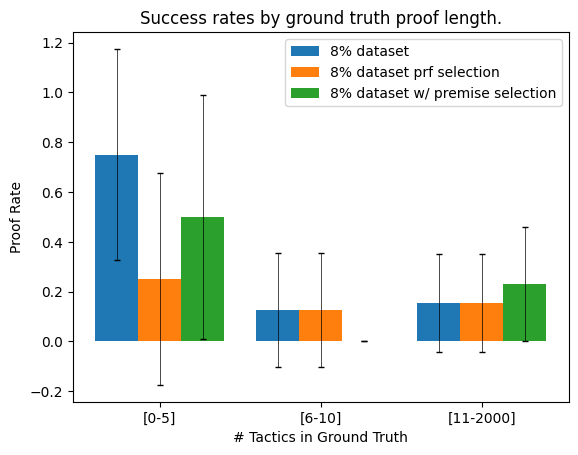

In [15]:
plot_by_ground_truth(error_free_names, error_free_eval)

In [16]:
time_boxplot(error_free_names, error_free_eval)

NameError: name 'time_boxplot' is not defined